<h1 style='color:#333399'> OptiLender Loss Model</h1>

<h2 style='color:#6698FF'> Table of Contents</h2>
<a name="TOC"></a> 

1.  [Summary](#1)
2.  [Import Libraries and Data](#2)   
3.  [Data Cleaning](#3)
4.  [Calculate Return in 12 Months](#4)  
    4.1.  [Add Loss Month](#4.1)   
    4.2.  [Calculate Return](#4.2) 
5.  [Model: Decision Tree Regressor](#5)  
    5.1.  [Build OptiLender and Benchmark Model](#5.1)   
6.  [Model Results and Comparison](#6)  
7.  [Generate Output Files](#7)  

<a name="2" style='color:#6698FF'>
## Import Libraries and Data </a>
[Back to Table of Contents](#TOC)

Basic steps for reading in the data, configuring settings, and including all necessary libraries
#### Libraries

In [1]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import preprocessing, metrics

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 50)

#### Data Import
Connect to the postgres database and pull the relevant data into the notebook

In [2]:
try:
    conn = psycopg2.connect("dbname=p2p_lending user=daniel")
except:
    print "I am unable to connect to the database"
    
cur = conn.cursor()

In [3]:
#Pull Loan Data from loans_nodups and join with desired Listing data
cur.execute("""SELECT loans_nodups.*
                        ,listings.listing_number
                        ,borrower_state
                        ,income_range
                        ,dti_wprosper_loan
                        ,months_employed
                        ,prior_prosper_loans
                        ,all001
                        ,all003
                        ,all021
                        ,all022
                        ,all201
                        ,all208
                        ,all701
                        ,all720
                        ,real_estate_balance
                        ,current_delinquencies
                        ,delinquencies_last7_years
                        ,public_records_last10_years
                        ,public_records_last12_months
                        ,inquiries_last6_months
                        ,open_credit_lines
                        ,bankcard_utilization
                        ,installment_balance
                        ,real_estate_balance
                        ,revolving_balance
                        ,real_estate_payment
                        ,revolving_available_percent
                        ,total_inquiries
                        ,total_trade_items
                        ,satisfactory_accounts
                        ,now_delinquent_derog
                        ,was_delinquent_derog
                        ,oldest_trade_open_date
                        ,delinquencies_over30_days
                        ,delinquencies_over60_days
                        ,delinquencies_over90_days
                        ,is_homeowner

                        
                FROM listings, 
                     loans_nodups 
                WHERE listings.listing_number = loans_nodups.listing_number;
            """)

In [4]:
#Get data and store in a pandas dataframe
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
Loans = pd.DataFrame(rows,columns =colnames )

#Show size and head
print Loans.shape
Loans.head()

(291614, 62)


,loan_number,amount_borrowed,borrower_rate,prosper_rating,term,age_in_months,origination_date,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,prosper_fees_paid,late_fees_paid,debt_sale_proceeds_received,loan_status,loan_status_description,loan_default_reason,loan_default_reason_description,next_payment_due_date,next_payment_due_amount,payment,simple_return,listing_number,analysis_class,...,all701,all720,real_estate_balance,current_delinquencies,delinquencies_last7_years,public_records_last10_years,public_records_last12_months,inquiries_last6_months,open_credit_lines,bankcard_utilization,installment_balance,real_estate_balance,revolving_balance,real_estate_payment,revolving_available_percent,total_inquiries,total_trade_items,satisfactory_accounts,now_delinquent_derog,was_delinquent_derog,oldest_trade_open_date,delinquencies_over30_days,delinquencies_over60_days,delinquencies_over90_days,is_homeowner
0,541784,7000.0,0.1017,A,36,9,2016-01-05,0,5444.37,-42.80,1376.20,435.24,0.0,0.0,0.0,1,CURRENT,NaN,None,2016-11-05,226.43,226.429421,0.258777,4413385,0,...,234.0,22.0,NaN,1.0,19.0,1.0,0.0,0.0,7.0,0.77,36599.0,NaN,18691.0,NaN,38.0,10,28,23,1,4,None,5,5,19,False
1,543616,6500.0,0.2095,D,60,9,2016-01-07,0,5900.40,-41.94,526.80,878.48,0.0,0.0,0.0,1,CURRENT,NaN,None,2016-10-07,0.00,175.664067,0.216197,4420264,0,...,135.0,9999.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.89,0.0,0.0,12094.0,0.0,14.0,6,15,14,0,1,None,6,0,0,False
2,541922,2000.0,0.1512,C,60,9,2016-01-06,0,0.00,-2.41,2000.00,36.34,0.0,0.0,0.0,4,COMPLETED,NaN,None,2016-03-06,47.71,47.705932,1.018170,4437006,0,...,328.0,9999.0,NaN,0.0,0.0,0.0,0.0,0.0,7.0,0.55,6942.0,NaN,5883.0,NaN,53.0,3,20,20,0,0,None,0,0,0,False
3,544621,18000.0,0.1319,B,36,9,2016-01-08,0,12104.36,-115.29,5895.64,1520.73,0.0,0.0,0.0,1,CURRENT,NaN,None,2016-10-08,0.00,608.139732,0.412021,4433395,0,...,191.0,3.0,NaN,0.0,0.0,0.0,0.0,2.0,11.0,0.51,NaN,NaN,22794.0,NaN,50.0,4,22,21,0,1,None,1,0,0,False
4,549528,12000.0,0.1280,B,60,9,2016-01-11,0,10808.04,-76.75,1191.96,982.52,0.0,0.0,0.0,1,CURRENT,NaN,None,2016-10-11,271.81,271.809866,0.181207,4459926,0,...,370.0,66.0,286428.0,0.0,3.0,0.0,0.0,1.0,16.0,0.54,37669.0,286428.0,13255.0,1733.0,53.0,2,48,47,0,1,None,1,1,3,True


<a name="3" style='color:#6698FF'>
## Data Cleaning </a>
[Back to Table of Contents](#TOC)

Add some new fields, change dates to datetime.

In [5]:
#Convert date fields to Python datetimes
Loans["origination_date"] = pd.to_datetime(Loans["origination_date"]
                                           ,infer_datetime_format=True)
Loans["next_payment_due_date"] = pd.to_datetime(Loans["next_payment_due_date"]
                                                ,infer_datetime_format=True)

#Isolate origination year from the origination date
Loans["Orig_Year"] = Loans["origination_date"].map(lambda x: x.year)

def get_orig_month(x):
    if x.month < 10: return str(x.year)+'0'+str(x.month)
    else: return str(x.year)+str(x.month)
    
#Convert orig date to an orig year_month (yyymm)
Loans['orig_month']  = Loans['origination_date'].map(lambda x: get_orig_month(x))

#Rank order prosper ratings
ratings = ["AA", "A", "B", "C", "D", "E", "HR"]
Loans['prosper_rating'] = pd.Categorical(Loans['prosper_rating'], ratings)

<a name="4" style='color:#6698FF'>
## Calculate Return in 12 Months </a>
[Back to Table of Contents](#TOC)

Our metric of performance is the net return in the first 12 months of the loan, but the dataset contains only a snapshot of the loan as of the current date. For loans older than 12 months, we need to determine what proportions of the return occurred in the first year.

The two largest components of expected return are **Interest Income** and **Principal Loss**. These are the two components we need to address.

<a name="4.1">
### Add Loss Month </a>
[Back to Table of Contents](#TOC)

We can identify loans that defaulted but not the time of default. We need to back into the month the customer stopped paying by comparing interest and principal expectations to the actual interest and principal received.

#### Loss Month Functions

In [6]:
#Loan payment calculator based on loan amount, interest rate, and term
def loan_payment(loan, ir, n):
    payment = loan * ((ir * ((1+ir) ** n)) / ((1+ir) ** n - 1))
    return payment

#Approximate the month payments stopped using the expected loan amortization schedule
def loss_month_approx(loan, ir, n, act_principal_paid, act_int_paid, mob):
    try:
        pmt = loan_payment(loan,ir,n) #Monthly payment given loan details
        current_bal = loan            #Current balance at start of loan is the loan amount
        principal_paid = 0            #Principal paid at start is 0
        int_paid = 0                  #Interest paid at start is 0
    
        #For months in term of the loan
        for i in range(1,n+1):
            current_bal = current_bal*(1+ir)-pmt  #Calculate next months balance
            principal_paid = loan - current_bal   #Update total principal paid
            int_paid = pmt*i-principal_paid       #Update total interest paid
            
            #If expected principal paid is greater than actual, we've found the approximate stop month
            if principal_paid > act_principal_paid: break
            #Or if expected principal is within 5% of the actual
            elif abs(principal_paid/act_principal_paid-1) <0.05: break

        #If the loop went beyond the Months on Books, return error
        if i>mob: return [np.nan,np.nan,np.nan]
        
        #Else, return the month of stopped payment, the variance in actual and expected principal,
        # and the variance in actual and expected interest.
        else: return [i, round(principal_paid/act_principal_paid-1,4),
                      round(int_paid/act_int_paid-1,4)]
    
    #For loans missing the necessary information, return error
    except:
        return [np.nan,np.nan,np.nan]

#### Call functions on Charged-off Accounts

In [7]:
start_time = time.time()

#Calculate only on Defaulted and Charged-off population
loss_status = ["CHARGEOFF","DEFAULTED"]
Loss = Loans[Loans["loan_status_description"].isin(loss_status)]\
            [['loan_number', 'amount_borrowed', 'borrower_rate', 'age_in_months', 'term', 
              'origination_date', 'days_past_due', 'principal_balance','principal_paid', 
              'interest_paid','late_fees_paid', 'loan_status', 'next_payment_due_date', 
              'next_payment_due_amount', 'payment', 'Orig_Year']]\
            .reset_index(drop=True)

#Loop through all Defaulted loans and calculate month stopped paying
output = [] 
for i in range(0,len(Loss)):
    output.append(loss_month_approx(Loss.iloc[i]["amount_borrowed"]
                                    ,Loss.iloc[i]["borrower_rate"]/12
                                    ,Loss.iloc[i]["term"]
                                    ,Loss.iloc[i]["principal_paid"]
                                    ,Loss.iloc[i]["interest_paid"]
                                    ,Loss.iloc[i]['age_in_months']))
    
print time.time() - start_time

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars


30.7983949184


#### Process Output

In [8]:
#Add calculated fields back to Loss dataframe
output = pd.DataFrame(output, columns=['stopped_payment', 'principal_error','interest_error'])
Loss = pd.concat([Loss, output], axis=1, join='outer')

#Time of loss given time of stopped payment,
Loss["loss_month"] = Loss["stopped_payment"]+3
Loss["loss_month"].loc[Loss["stopped_payment"]==-1] =-1

#Flag if loss occurred in first 12 months
Loss["Loss_12M"]=0
Loss["Loss_12M"].loc[(Loss["loss_month"]<=12)&(Loss["loss_month"]>0)] =1

#Flag if payment stopped in first 12 months
Loss["Stopped_Payment_12M"]=0
Loss["Stopped_Payment_12M"].loc[(Loss["stopped_payment"]<=12)&(Loss["stopped_payment"]>0)] =1

#Flag for late payments
Loss["late_payments"]=0
Loss["late_payments"].loc[(Loss["late_fees_paid"]>0)] =1

#Replace infinity data with missing
Loss['interest_error'] = Loss['interest_error'].replace([np.inf, -np.inf], np.nan)
Loss['principal_error'] = Loss['principal_error'].replace([np.inf, -np.inf], np.nan)

#Summarize output
Loss[["loan_number",'Loss_12M',"late_payments"]].groupby(['Loss_12M','late_payments'])\
                .count().reset_index()

,Loss_12M,late_payments,loan_number
0,0,0,9406
1,0,1,5024
2,1,0,9216
3,1,1,2329


#### Analyze Output
Initial analysis shows that our stopped month principal calculations were within 10% of actuals over 97.5% of the time. This should be expected given the method of our calculation.

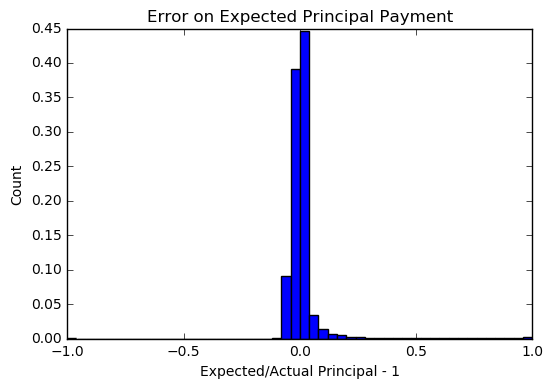

 % Error    % of Population     
    0%            0.00%
    5%           87.06%
   10%           97.52%
   15%           98.13%
   20%           98.82%


In [9]:
data_temp = Loss['principal_error'].dropna()
data_temp[data_temp>1] = 1
data_temp[data_temp<-1] = -1

weights = np.ones_like(data_temp)/len(data_temp)

x = plt.hist(data_temp,50,range=[-1,1],weights=weights)
plt.title("Error on Expected Principal Payment")
plt.xlabel('Expected/Actual Principal - 1')
plt.ylabel('Count')
plt.show()

print " {0:10}".format("% Error"), "{0:20}".format("% of Population")
temp = pd.DataFrame([x[1],x[0]]).T
for i in np.arange(0,0.25,0.05):   
    print "{0:5.0f}%".format(i*100), "{0:15.2f}%".format(100.0*temp[temp[0].apply(abs)<i][1].sum())

However, that accuracy drops dramatically for expected interest calculations. Only 77% are within 10% accuracy of the actual interest. This error is heavily concentrated on the lower side of the equation, so our projection of month of stopped payment underestimates expected interest.

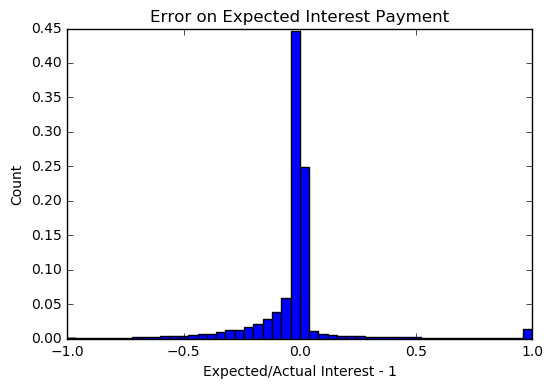

 % Error    % of Population     
    0%            0.00%
    5%           70.54%
   10%           77.14%
   15%           81.50%
   20%           87.07%


In [10]:
data_temp = Loss['interest_error'].dropna()
data_temp[data_temp>1] = 1
data_temp[data_temp<-1] = -1

weights = np.ones_like(data_temp)/len(data_temp)

x = plt.hist(data_temp,50,range=[-1,1],weights=weights)
plt.title("Error on Expected Interest Payment")
plt.xlabel('Expected/Actual Interest - 1')
plt.ylabel('Count')
plt.show()

print " {0:10}".format("% Error"), "{0:20}".format("% of Population")
temp = pd.DataFrame([x[1],x[0]]).T
for i in np.arange(0,0.25,0.05):   
    print "{0:5.0f}%".format(i*100), "{0:15.2f}%".format(100.0*temp[temp[0].apply(abs)<i][1].sum())

This underprediction can be largely explained by accounts with late fees. These are customers who eventually default and chargeoff, but continue to make payments after missing their first. This will lead to higher accrued interest and thus higher interest income for the lender. Excluding the late fee payers (about 20%), roughly 93% of loans are with 10% accuracy.

Because the month of stopped payment is most relevant in determining the amount of principal the lender can expect to receive back, **we determined to take a conservative approach and not push back the actual month of default to adjust for missed payments.** If a borrower paid back 11 months of principal over 13 months, we will include the loss in the first year. The additional revenue will still be incorporated in the expected return segmentation model.

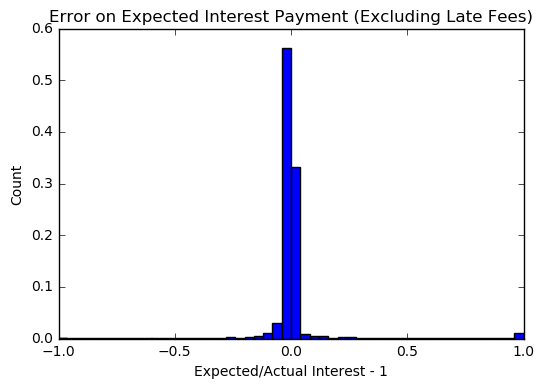

 % Error    % of Population     
    0%            0.00%
    5%           90.31%
   10%           93.83%
   15%           95.28%
   20%           96.59%


In [11]:
data_temp = Loss[Loss.late_payments==0]['interest_error'].dropna()
data_temp[data_temp>1] = 1
data_temp[data_temp<-1] = -1

weights = np.ones_like(data_temp)/len(data_temp)

x = plt.hist(data_temp,50,range=[-1,1],weights=weights)
plt.title("Error on Expected Interest Payment (Excluding Late Fees)")
plt.xlabel('Expected/Actual Interest - 1')
plt.ylabel('Count')
plt.show()

print " {0:10}".format("% Error"), "{0:20}".format("% of Population")
temp = pd.DataFrame([x[1],x[0]]).T
for i in np.arange(0,0.25,0.05):   
    print "{0:5.0f}%".format(i*100), "{0:15.2f}%".format(100.0*temp[temp[0].apply(abs)<i][1].sum())

#### Add Loss Back to Loans Data

In [12]:
Loans = Loans.merge(Loss[['loan_number','Loss_12M','Stopped_Payment_12M','late_payments'
                          ,'stopped_payment','loss_month']]
                     ,on='loan_number'
                     ,how='left')

#Fill missing data with 0
Loans["Loss_12M"] = Loans["Loss_12M"].fillna(0)
Loans["late_payments"] = Loans["late_payments"].fillna(0)
Loans["stopped_payment"] = Loans["stopped_payment"].fillna(0)
Loans["loss_month"] = Loans["loss_month"].fillna(0)
Loans["Stopped_Payment_12M"] = Loans["Stopped_Payment_12M"].fillna(0)

<a name="4.2">
### Calculate Return </a>
[Back to Table of Contents](#TOC)

Estimate the expected interest revenue in the first 12 months using the interest rate and payment. Adjust based on the prepayment rates we've observed in the Prosper data in the first year. 

Combine interest revenue with loss and fees to calculate an expected return.

#### Function to Calculate Expected Interest in First 12 Months

In [13]:
def interest_approx(loan, ir, n, act_principal_paid, act_interest_paid):
    
    #Inferred from other Prosper data in the first 12 months. 
    prepayment_rate = 0.1
    
    try:
        pmt = loan_payment(loan,ir,n)  #Monthly payment given loan details
        current_bal = loan             #Current balance at start of loan is the loan amount
        exp_principal_paid = 0         #Principal paid at start is 0
        exp_interest_paid = 0          #Interest paid at start is 0
         
        #For the first 12 months
        for i in range(1,13):
            current_bal = current_bal*(1+ir)-pmt             #Calculate next months balance
            exp_principal_paid = loan - current_bal          #Update total principal paid
            exp_interest_paid = pmt*12 - exp_principal_paid  #Update total interest paid
 
        #Return the expected interest less the prepayment expecations.
        return exp_interest_paid*(1-prepayment_rate)
    
    #For loans missing the necessary information, return error
    except:
        return -1

#### Applying the interest function on all loans

In [14]:
Loans["exp_interest_paid_12M"] = Loans.apply(lambda x: interest_approx(x['amount_borrowed'], 
                                                         x['borrower_rate']/12,
                                                         x['term'],
                                                         x['principal_paid'],
                                                         x['interest_paid']), axis=1)

#### Expected Return Calculation
We define expected return for the first year as interest received in the first 12 months less principal lost due to lack of repayment, plus any applicable fees.

In [15]:
#Use actual interest paid instead of predicted for loans that stopped payment in first 12M
Loans["exp_interest_paid_12M"].loc[Loans["Stopped_Payment_12M"]==1] = Loans["interest_paid"]

#Calculate a dollar loss amount
Loans["loss"] = 0
Loans["loss"]= (Loans["amount_borrowed"]-Loans["principal_paid"])*Loans['Loss_12M']

#Calculate an expected dollar return in the first 12M
Loans["exp_return_12M"] = Loans["exp_interest_paid_12M"] - Loans["loss"] + \
                            Loans["prosper_fees_paid"] + Loans["late_fees_paid"] +\
                            Loans["service_fees_paid"] + Loans["debt_sale_proceeds_received"]
        
#Calculate as a rate of original loan amount
Loans["Return"] = Loans["exp_return_12M"]/Loans["amount_borrowed"]

#Show average Loss and Return rates by Prosper Rating Grade
Loans[Loans["age_in_months"]>=12][["prosper_rating","Loss_12M",'Return']]\
        .groupby(["prosper_rating"]).mean().reset_index()

,prosper_rating,Loss_12M,Return
0,A,0.017797,0.053693
1,AA,0.009203,0.037623
2,B,0.031971,0.067949
3,C,0.051597,0.081715
4,D,0.076332,0.097452
5,E,0.100557,0.116200
6,HR,0.149433,0.038009


<a name="5" style='color:#6698FF'>
## Model: Decision Tree Regressor </a>
[Back to Table of Contents](#TOC)

Our model is built using a Decision Tree Regressor. This approach allows us to model a continuous variable (rate of expected return), while maintaining the explainability of a tree. The decision tree structure also classifies each loan in the portfolio into a end node, which is conducive to our end goal of dividing the portfolio into high-performance and low-performance pools.

#### Field Selection and Preparation

In [16]:
fields = ['prosper_rating','borrower_state', 'months_employed',
          'dti_wprosper_loan','total_inquiries','bankcard_utilization','all208',
          'revolving_balance','all701','installment_balance']

#Build Encoder for categorical variables for SKlearn model
enc = preprocessing.LabelEncoder()
enc.fit(Loans['prosper_rating'])

enc2 = preprocessing.LabelEncoder()
enc2.fit(Loans['borrower_state'])

LabelEncoder()

#### Function to Calculate the Standard Deviation by Group in Data

In [17]:
# "group" is the segmentation to pool by
# "data" is the pandas dataframe with the loan level returns
def std_by_group(group, data, n=25, samples=100):
    #Create a dataframe for results
    group_returns = pd.DataFrame(columns = [group,'avg_return','std_return'])    
    
    #For each unique category in the group field
    for i in data[group].unique():
        returns = [] #Empty list for storing average returns
        
        x = data[data[group]==i] #Select only the current category

        #For the number of samples specified (default is 100)
        for j in range(0,samples):
            #Select a random sample of n loans within the current category, default is 25
            z = x[[group,'exp_return_12M','amount_borrowed']].sample(n=min(n,len(x))).sum()
            
            #Append the average return to the returns array
            returns.append(z['exp_return_12M']/z['amount_borrowed'])

        #Calculate the average return and standard deviation of returns, and store in a 
        # temporary data frame with the category name
        temp = pd.DataFrame([[i, x['exp_return_12M'].sum()/x['amount_borrowed'].sum()
                              ,np.std(returns)]]
                            ,columns=[group,'avg_return','std_return'])
        
        #Append the current category results to the total dataframe
        group_returns = group_returns.append(temp)    
    
    #Return the dataframe of returns and standard deviations by group
    return group_returns.reset_index(drop=True)

<a name="5.1">
### Build OptiLender and Benchmark Model </a>
[Back to Table of Contents](#TOC)

We build one model for each origination year. We took only loans that were at least 12 months old at the beginning of the origination year. For example, the 2010 model uses only 2007 and 2008 originations because the 2009 data is too young. At the start of each new origination year, we update the model with another 12 months of data and recalibrate. Prosper’s exponential growth creates a natural weighting system for the age of the data, so that newer loans have a much higher weight in the model calibration but we still retain older performance for stability.


Our benchmark model is built in the same way, but only using the Prosper Rating as an independent variable. The only other difference is that the actual return of C, D, and E ratings shifted drastically after 2008 originations, possibly due to a change in the rating grade model at Prosper following the economic crash. Due to this, we exclude 2007 and 2008 data when 2009 becomes available for use. Otherwise, this older performance data heavily drags down the expected return.

In [18]:
for year in [2010,2011,2012,2013,2014,2015]:
    #Start timer
    start_time = time.time()    
    
    #-------------------#
    #----BUILD MODEL----#
    #-------------------#
    
    #Set train and test populations
    Train_Data = Loans.loc[(Loans["age_in_months"]>=12) & (Loans['Orig_Year']<year-1)]
    test =  Loans.loc[(Loans["age_in_months"]>=12) & (Loans['Orig_Year']==year)]
#     print year, ":", Train_Data.shape[0], test.shape[0]

    #Encode categorical variables
    Train_Data['prosper_rating'] = enc.transform(Train_Data['prosper_rating'])
    test['prosper_rating'] = enc.transform(test['prosper_rating'])
    Train_Data['borrower_state'] = enc2.transform(Train_Data['borrower_state'])
    test['borrower_state'] = enc2.transform(test['borrower_state'])

    #Dependent and independent variables
    train_Y = Train_Data['Return']
    train_X = Train_Data[fields].fillna(0)
    test_Y = test['exp_return_12M']
    test_X = test[fields].fillna(0)

    #Build model on train data
    DTC = DecisionTreeRegressor(min_samples_leaf =100)    
    DTC = DTC.fit(train_X, train_Y)
    Train_Data['leaf'] = DTC.apply(train_X)

    #Run model on test data
    test["pred"] = DTC.predict(test_X)
    test["pred_return"] = test["pred"]*test['amount_borrowed']
    test['leaf'] = DTC.apply(test_X)
    
    
    #------------------------------------------------------#
    #----CALCULATE EXPECTED AND AVERAGE RETURNS BY LEAF----#
    #------------------------------------------------------#  
    
    #Aggregate returns to the leaf level
    returns = test.groupby('leaf').sum().reset_index()\
            [['leaf','pred_return','exp_return_12M','amount_borrowed']]
    
    #Calculate expected and actual returns by leaf
    returns['pred_return_rate'] = returns['pred_return']/returns['amount_borrowed']
    returns['exp_return_rate'] = returns['exp_return_12M']/returns['amount_borrowed']
    returns=returns.drop(['pred_return'], axis=1)

    #Calculate expected standard deviations of returns by leaf
    sd = std_by_group('leaf', Train_Data, n=25, samples=100)
    sd.leaf = sd.leaf.astype(int)
    returns = returns.merge(sd, on='leaf')
    
    #Rename columns
    returns = returns.drop(['avg_return'], axis=1)
    returns.columns = ['leaf','Act_Return_Dollars','Amount_Borrowed','Pred_Return_Rate',
                               'Act_Return_Rate','Pred_Std']
    
    #Add year, node, and list of loans within the leaf
    returns['year'] = year
    returns['Node_ID'] = returns['year'].astype(str) + returns['leaf'].astype(str)
    returns['Loans'] = test.groupby('leaf')['loan_number'].apply(list).reset_index(drop=True)
    
    
    #-----------------------------#
    #----BUILD BENCHMARK MODEL----#
    #-----------------------------#
    
    #Exclude 2007-2008 data after 20101
    if year>=2011:
        Train_Data = Train_Data.loc[(Train_Data['Orig_Year']>=2009)]
        
    #Calculate expected returns and standard deviations of returns by Prosper Rating
    rating_returns = std_by_group('prosper_rating', Train_Data, n=25, samples=100)
    rating_returns.prosper_rating = enc.inverse_transform(rating_returns.prosper_rating.astype(int))

    #Calculate actual returns and standard deviations of returns by Prosper Rating
    rating_sd = std_by_group('prosper_rating', test, n=25, samples=100)
    rating_sd.prosper_rating = enc.inverse_transform(rating_sd.prosper_rating.astype(int))    
    rating_returns = rating_returns.merge(rating_sd, on='prosper_rating')
    
    #Add year and node
    rating_returns.columns = ['prosper_rating','Prev_Return','Prev_SD','Act_Return', 'Act_SD']
    rating_returns['year'] = year
    
    
    #-----------------------#
    #----COMBINE RESULTS----#
    #-----------------------#    
    
    #Merge results from different years
    if year==2010: 
        total_returns = returns.copy()
        total_rating_returns = rating_returns.copy()
    else: 
        total_returns = pd.concat([total_returns, returns])
        total_rating_returns = pd.concat([total_rating_returns, rating_returns])
        
    #Print runtime for each origination year
    print '%i runtime is %0.2fs' %(year,time.time() - start_time)
    print ''   
    
#Reset indexes
total_returns = total_returns.reset_index(drop=True)
total_rating_returns = total_rating_returns.reset_index(drop=True)

2010 runtime is 14.67s

2011 runtime is 16.13s

2012 runtime is 20.67s

2013 runtime is 27.70s

2014 runtime is 40.93s

2015 runtime is 64.08s



#### Feature Weights

In [19]:
#Get variable importance, standard deviation of importance, and variable index
importances = DTC.feature_importances_
indices = np.argsort(importances)[::-1]

#Convert variable index into a name
names = np.array(train_X.columns.values)
dt_names = []
for i in indices:
    dt_names.append(names[i])

# Print the feature ranking
print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], dt_names[f], importances[indices[f]]))

Feature ranking:
1. feature 0, prosper_rating (0.276160)
2. feature 4, total_inquiries (0.106184)
3. feature 6, all208 (0.097782)
4. feature 7, revolving_balance (0.092201)
5. feature 2, months_employed (0.090805)
6. feature 9, installment_balance (0.082156)
7. feature 3, dti_wprosper_loan (0.075490)
8. feature 5, bankcard_utilization (0.075127)
9. feature 8, all701 (0.054239)
10. feature 1, borrower_state (0.049854)


<a name="6" style='color:#6698FF'>
## Model Results and Comparison </a>
[Back to Table of Contents](#TOC)

To evaluate the performance of the model, we compare to the Benchmark model built using only Prosper Rating grade as a feature. The user of our tool would select a distribution of Prosper Rating grades according to their risk appetite. Our model would select pools with comparable or lower expected standard deviation of returns (RISK) and comparable or higher average returns (RETURNS). We then compare actual returns over the next 12 months.

The model performs best on the lowest risk ratings (AA, A, B), providing substantial lift in expected returns by identifying pockets of the best return. The model performs comparably for medium risk ratings (C), and underperforms for the highest risk ratings (D, E).

         RATING  AA        
-----------------------------------
Year    Model  Benchmark Variance
-----------------------------------
2010    9.82%    4.76%    5.06%
2011    8.95%    4.60%    4.35%
2012    8.40%    4.71%    3.69%
2013    8.58%    4.21%    4.38%
2014    6.44%    3.65%    2.79%
2015    5.76%    3.41%    2.36%
         RATING  A        
-----------------------------------
Year    Model  Benchmark Variance
-----------------------------------
2010    9.62%    5.34%    4.28%
2011    9.43%    6.42%    3.01%
2012    8.13%    5.85%    2.29%
2013    9.06%    6.43%    2.63%
2014    6.89%    5.63%    1.25%
2015    6.09%    5.00%    1.10%
         RATING  B        
-----------------------------------
Year    Model  Benchmark Variance
-----------------------------------
2010   10.54%    8.83%    1.71%
2011    9.80%    8.78%    1.02%
2012   10.48%    7.93%    2.55%
2013   10.24%    8.86%    1.38%
2014    7.92%    6.98%    0.94%
2015    6.85%    5.91%    0.94%
         RATING  C      

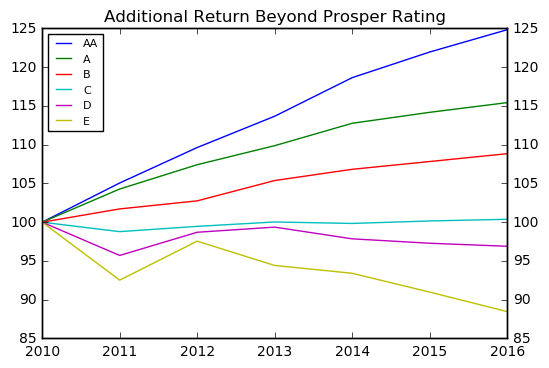

In [20]:
years = [2010,2011,2012,2013,2014,2015]
fig, ax = plt.subplots()

#Evaluate the model by comparing performance to the benchmark at each Rating
for rating in ['AA','A','B','C','D','E']:
    #Print formatting
    print "         RATING  " + rating + '        '
    print "-"*35
    print "{0:7} {1:6} {2:7} {3:7}".format("Year", "Model", "Benchmark", "Variance")
    print "-"*35

    cumulative_return = 100
    variances = [100]
    
    # For each origination year (and model)
    for year in years:
        
        # Minimum required return is the average expected return for the current Rating
        min_return = total_rating_returns[(total_rating_returns.prosper_rating==rating) 
                                          & (total_rating_returns.year == year)]['Prev_Return'].iloc[0]
        
        # Maximum risk is the average standard deviation of returns for the current Rating
        max_sd = total_rating_returns[(total_rating_returns.prosper_rating==rating) 
                                          & (total_rating_returns.year == year)]['Prev_SD'].iloc[0]

        #Select pools that meet the minimum return and maximum risk requirements
        recommendations = total_returns[(total_returns.Pred_Return_Rate >= min_return) 
                             & (total_returns.Pred_Std <= max_sd)
                             & (total_returns.year == year)]

        #Calculate weighted average actual return for recommended pools
        recommendations['Pred_Dollars'] = recommendations['Pred_Return_Rate'] \
                                            *recommendations['Amount_Borrowed']
        model_return = recommendations['Act_Return_Dollars'].sum()\
                            /recommendations['Amount_Borrowed'].sum()

        #Select average actual return for Prosper Rating
        rating_return = total_rating_returns[(total_rating_returns.prosper_rating==rating) 
                                          & (total_rating_returns.year == year)]['Act_Return'].iloc[0]

        #Calculate variance between model and benchmark
        variance = model_return - rating_return
        
        #Updated cumulative return
        cumulative_return*=(1+variance)
        variances.append(cumulative_return)

        #Print table of actual returns and variances
        print "{0:0.0f} {1:7.2f}% {2:7.2f}% {3:7.2f}%".format(year, model_return*100
                                                    , rating_return*100 ,variance*100) 
    print '=='*18
    
    #Plot the cumulative returns over time
    ax.plot(years+[2016],variances, label=rating)

#Duplicate y-axis on right side of chart
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
    
#Plot formatting
ax.ticklabel_format(useOffset=False)
ax.legend(loc=0,prop={'size':8})
plt.title("Additional Return Beyond Prosper Rating")
plt.show()

### Efficient Frontier

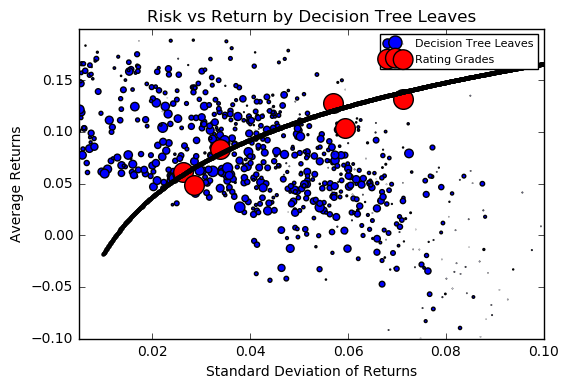

In [21]:
#Summarize leaf data
temp_leaf = total_returns.groupby('leaf')[['Pred_Return_Rate','Pred_Std']].mean().reset_index()
temp_leaf2 = total_returns.groupby('leaf')[['Amount_Borrowed']].sum().reset_index()
temp_leaf = temp_leaf.merge(temp_leaf2, on='leaf')

#Summarize Rating data
temp_rr = total_rating_returns[(total_rating_returns.year>2010)\
                               &(total_rating_returns.prosper_rating<>'HR')]\
            .groupby('prosper_rating')[['Prev_Return','Prev_SD']].mean().reset_index()


#Make marker size proportionate to leaf exposure
x = temp_leaf['Amount_Borrowed']/300000    

#Plot risk vs return for Leaf and Prosper Ratings
plt.scatter(temp_leaf['Pred_Std'],temp_leaf['Pred_Return_Rate']
            ,s=x ,c='b', label='Decision Tree Leaves')
plt.scatter(temp_rr['Prev_SD'],temp_rr['Prev_Return'],s=200, c='red', label='Rating Grades')


#Prosper Rating Grade curve
temp_range = np.arange(0.01,0.12,0.0001)
temp_y = []
for i in temp_range:
    temp_y.append(0.08*math.log(i) + 0.35)
plt.scatter(temp_range,temp_y ,c='black', s=5)

#Cutoff < 0.5% Std Deviation. Below that we assume too little data
plt.xlim([0.005,0.1])
plt.ylim([-0.1,0.2])

#Plot formatting
plt.legend(loc=0,prop={'size':8})
plt.xlabel('Standard Deviation of Returns')
plt.ylabel('Average Returns')
plt.title('Risk vs Return by Decision Tree Leaves')
plt.show()

<a name="7" style='color:#6698FF'>
## Generate Output Files </a>
[Back to Table of Contents](#TOC)


In [22]:
Loan_Data = Loans[(Loans["age_in_months"]>=12) & (Loans["Orig_Year"]>=2010)]\
                [['loan_number','Orig_Year']+fields]\
                .reset_index(drop=True)
        
for i in range(0,len(total_returns)):
    leaf = total_returns.ix[i]['leaf']
    loans = total_returns.ix[i]['Loans']
    Loan_Data.loc[Loan_Data.loan_number.isin(loans), 'leaf'] = leaf
    
Loan_Data['leaf'] = Loan_Data['leaf'].astype(int)
Loan_Data['Node_ID'] = Loan_Data['Orig_Year'].astype(str) + Loan_Data['leaf'].astype(str)


In [23]:
Loan_Data.to_csv('Loan_Data.csv', index=0)
total_returns.to_csv('total_returns.csv', index=0)
total_rating_returns.to_csv('total_rating_returns.csv', index=0)